In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from selectinf.base import selected_targets
from selectinf.base import restricted_estimator
import regreg.api as rr
import scipy.stats
from scipy.stats import norm as ndist

from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)

# Data Cleaning

In [226]:
data_raw = pd.read_csv("data_groups_dummy_encoded.csv")

In [227]:
data_raw

,SEQN,depressed,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,...,RIAGENDR_man,DMDBORN4_US,ALQ111_dummy,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion
0,109273,1,36,0.83,21.9,2,0,7,0,0,...,1,1,1,0,0,0,1,0,0,0
1,109274,0,68,1.20,30.2,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
2,109282,0,76,3.61,26.6,1,1,8,0,0,...,1,1,1,0,1,1,1,0,1,0
3,109292,0,58,1.60,30.5,2,10,3,0,1,...,1,1,1,0,1,1,0,1,0,0
4,109293,0,44,0.02,30.1,3,7,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,124814,0,64,2.00,37.5,3,1,2,0,0,...,1,1,1,0,0,0,1,0,0,0
5981,124815,0,52,5.00,29.5,1,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
5982,124817,0,67,2.19,37.9,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5983,124818,0,40,3.82,38.2,4,5,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [228]:
DBQ197 = data_raw[["DBQ197_never","DBQ197_often",
        "DBQ197_rarely", "DBQ197_sometimes"]].to_numpy()

In [229]:
(data_raw["ALQ111_dummy"] != 1).sum()

0

In [230]:
data_X = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy")

In [231]:
data_X.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [232]:
data_X = data_X.to_numpy()

In [233]:
np.linalg.matrix_rank(data_X)

47

In [234]:
data_X.shape

(5985, 47)

In [235]:
design_X = np.zeros((5985,48))
design_X[:,0] = np.ones((5985,))
design_X[:,1:48] = data_X

In [236]:
np.linalg.matrix_rank(design_X)

48

In [237]:
design_X.shape

(5985, 48)

In [238]:
design_X

array([[ 1.  , 36.  ,  0.83, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 68.  ,  1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 76.  ,  3.61, ...,  0.  ,  1.  ,  0.  ],
       ...,
       [ 1.  , 67.  ,  2.19, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 40.  ,  3.82, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 63.  ,  3.71, ...,  1.  ,  0.  ,  0.  ]])

# Construct Groups

In [239]:
data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [240]:
groups = np.zeros((48,))
groups[0] = int(0) # Intercept
# Singletons
for i in range(1,7):
    groups[i] = int(i)
# RIDRETH1
groups[7:11] = int(7)
# DMDEDUC2
groups[11:15] = int(8)
# DMDMARTZ
groups[15:17] = int(9)
# INDFMMPC
groups[17:19] = int(10)
# ALQ121
groups[19:29] = int(11)
# DBQ700
groups[29:33] = int(12)
# DBQ197
groups[33:37] = int(13)
# DIQ010
groups[37:39] = int(14)
# Singletons
for i in range(39,48):
    groups[i] = int(i-24)

groups = groups.astype(int)

In [241]:
def calc_avg_group_size(groups):
    sizes = []
    for g in range(np.max(groups)+1):
        g_flag = (groups == g)
        sizes.append(g_flag.sum())

    return sizes, np.mean(sizes)

In [242]:
sizes, avg_sizes = calc_avg_group_size(groups)

In [243]:
col_names = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns.values.tolist()
col_names = ['Intercept'] + col_names

In [244]:
# Sanity check for groupings
pd.DataFrame([groups,col_names])

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,1,2,3,4,5,6,7,7,7,...,14,15,16,17,18,19,20,21,22,23
1,Intercept,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,RIDRETH1_Non_Hispanic_White,...,DIQ010_diabetes_borderline,RIAGENDR_man,DMDBORN4_US,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion


In [245]:
n,p = design_X.shape
scaling_cts = np.ones((p,))
scaling_cts[1:7] = design_X.std(0)[1:7]
cts_logical = np.zeros((p,))
cts_logical[1:7] = 1.

In [246]:
print(np.linalg.matrix_rank(design_X))
scaling = design_X.std(0) * np.sqrt(n)
scaling[0] = np.sqrt(n)
scaling[7:p] = np.sqrt(n)

X_standardized = design_X - (cts_logical * design_X.mean(axis = 0))
print(np.linalg.matrix_rank(X_standardized))
X_standardized = X_standardized / scaling[None, :]
print(np.linalg.matrix_rank(X_standardized))

48
48
48


In [247]:
X_standardized[10:18,45:50]

array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.0129, 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ]])

# Inference Tools

In [248]:
def group_p_val(groups, nonzero, info_inv, MLE, colnames):
    nonzero_idx = np.unique(groups[nonzero])

    MLE_full = np.zeros((nonzero.shape[0],))
    info_inv_full = np.zeros((nonzero.shape[0], nonzero.shape[0]))
    info_full = np.zeros((nonzero.shape[0], nonzero.shape[0]))

    MLE_full[nonzero] = MLE
    info_inv_full[np.ix_(nonzero, nonzero)] = info_inv
    info = np.linalg.inv(info_inv)
    info_full[np.ix_(nonzero, nonzero)] = info

    p_vals = {}

    for g in nonzero_idx:
        g_idx = groups == g
        MLE_g = MLE_full[g_idx]

        info_g = info_full[g_idx][:, g_idx]
        info_inv_g = info_inv_full[g_idx][:, g_idx]

        df_g = g_idx.sum()

        if df_g == 1:
            pivot = (MLE_g ** 2 / info_inv_g)[0][0]

        else:
            pivot = MLE_g.T @ info_g @ MLE_g

        p_val = scipy.stats.chi2.sf(x=pivot, df=df_g)

        #print("Group Index:", g)
        #print("Variables:", np.asarray(col_names)[g_idx])
        #print("P-Value:", p_val)
        p_vals[g] = (p_val)

    return p_vals

In [249]:
from scipy.linalg import qr
def rank_deficiency_qr(A, tol=None):
    # Perform QR decomposition with column pivoting
    Q, R, P = qr(A, mode='economic', pivoting=True)
    # If tolerance is not provided, use a default one based on numerical precision
    if tol is None:
        tol = np.max(A.shape) * np.abs(np.diag(R)).max() * np.finfo(R.dtype).eps
    # Rank is determined by the number of diagonal elements larger than the tolerance
    rank = np.sum(np.abs(np.diag(R)) > tol)
    # Rank deficiency is the difference between the matrix size and its rank
    rank_deficiency = A.shape[1] - rank
    return rank_deficiency

In [250]:
def naive_inference(X, Y, n, p, groups, group_sizes,
                    weight_frac=1. / np.sqrt(avg_sizes),
                    level=0.9, select_only=False):
    # Selection
    p = X.shape[1]
    sigma_ = np.std(Y)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict(
        [(i, weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    if nonzero.sum() > 0:
        if select_only:
            return conv

        # E: nonzero flag
        X_E = X[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_E @ beta_MLE))

        f_info = X_E.T @ W @ X_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE + z_low * sd
        intervals_up = beta_MLE + z_up * sd
        intervals = np.asarray([intervals_low, intervals_up]).T

        # p-values
        Z_scores = beta_MLE / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        group_pvals = group_p_val(groups, nonzero, cov, beta_MLE, col_names)

        return beta_MLE, intervals, pvalues, nonzero, group_pvals

    # If no variable selected, no inference
    return None, None, None, None, None

In [251]:
def randomized_inference(X, Y, n, p, groups, group_sizes,
                         weight_frac=1. / np.sqrt(avg_sizes),
                         proportion=0.67,
                         randomizer_scale=None):
    hess = None
    if randomizer_scale is None:
        # Estimate randomizer covariance if not using isotropic randomization
        def estimate_hess():
            loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
            # For LASSO, this is the OLS solution on X_{E,U}
            beta_full = restricted_estimator(loglike, np.array([True] * p))
            def pi_hess(x):
                return np.exp(x) / (1 + np.exp(x)) ** 2

            # Calculation the asymptotic covariance of the MLE
            W = np.diag(pi_hess(X @ beta_full))

            return X.T @ W @ X * (1 - proportion) / proportion
        hess = estimate_hess()

    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac / np.sqrt(proportion) * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    if hess is not None:
        # Estimated randomization covariance
        #print("Estimated hessian used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                cov_rand = hess)
    else:
        # Isotropic
        #print("Isotropic randomization used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                randomizer_scale=randomizer_scale * sigma_)
    signs, soln = conv.fit()
    nonzero = signs != 0
    
    """if randomizer_scale is not None:
        print("Rank of X_E:", np.linalg.matrix_rank(X[:,nonzero]))
        print("Dim of X_E:", X[:,nonzero].shape[1])"""

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result,FInfo = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)

    pval = result['pvalue']
    MLestimates = result['MLE']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    group_pvals = group_p_val(groups, nonzero, FInfo, MLestimates, col_names)

    return MLestimates, intervals, pval, nonzero, group_pvals

In [252]:
def data_splitting(X, Y, n, p, groups, group_sizes, 
                   weight_frac=1. / np.sqrt(avg_sizes),
                   proportion=0.67, level=0.9):

    pi_s = proportion
    subset_select = np.zeros(n, bool)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)
    X_S = X[subset_select, :]
    Y_S = Y[subset_select]

    # Selection on the first subset of data
    p = X.shape[1]
    sigma_ = np.std(Y_S)
    # weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, np.sqrt(proportion) * weight_frac * np.sqrt(group_sizes[i]) * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.logistic(X=X_S,
                                successes=Y_S,
                                trials=np.ones(n1),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                perturb=np.zeros(p),
                                ridge_term=0.)

    signs, _ = conv.fit()
    # print("signs",  signs)
    nonzero = signs != 0

    n1 = subset_select.sum()
    n2 = n - n1

    if nonzero.sum() > 0:
        X_notS = X[~subset_select, :]
        Y_notS = Y[~subset_select]
        
        if rank_deficiency_qr(X_notS):
            return True, None, None, None, None, None

        # E: nonzero flag

        X_notS_E = X_notS[:, nonzero]

        # Solve for the unpenalized MLE
        def pi_hess(x):
            return np.exp(x) / (1 + np.exp(x)) ** 2

        loglike = rr.glm.logistic(X_notS, successes=Y_notS, trials=np.ones(n2))
        # For LASSO, this is the OLS solution on X_{E,U}
        beta_MLE_notS = restricted_estimator(loglike, nonzero)

        # Calculation the asymptotic covariance of the MLE
        W = np.diag(pi_hess(X_notS_E @ beta_MLE_notS))

        f_info = X_notS_E.T @ W @ X_notS_E
        cov = np.linalg.inv(f_info)

        # Standard errors
        sd = np.sqrt(np.diag(cov))

        # Normal quantiles
        z_low = scipy.stats.norm.ppf((1 - level) / 2)
        z_up = scipy.stats.norm.ppf(1 - (1 - level) / 2)
        assert np.abs(np.abs(z_low) - np.abs(z_up)) < 10e-6

        # Construct confidence intervals
        intervals_low = beta_MLE_notS + z_low * sd
        intervals_up = beta_MLE_notS + z_up * sd
        intervals = np.asarray([intervals_low,intervals_up]).T

        # p-values
        Z_scores = beta_MLE_notS / sd
        cdf_vals = ndist.cdf(Z_scores)
        pvalues = []
        for cdf in cdf_vals:
            pvalues.append(2 * min(cdf, 1 - cdf))

        group_pvals = group_p_val(groups, nonzero, cov, beta_MLE_notS, col_names)

        return False, beta_MLE_notS, intervals, pvalues, nonzero, group_pvals

    # If no variable selected, no inference
    return False, None, None, None, None, None

# Subsampling

In [253]:
from sklearn.model_selection import train_test_split
# Assuming `X` is your feature set and `Y` is your response variable
Y = data_raw["depressed"]

In [254]:
def stratified_sampling(design_X, Y, split_proportion=0.1):
    rank = design_X.shape[1]
    stop = False
    while not stop:
        X_train, X_test, Y_train, Y_test\
            = train_test_split(design_X, Y, test_size=split_proportion, stratify=Y)
        design_X_sub = X_test
        
        n, p = design_X_sub.shape
        scaling_cts = np.ones((p,))
        scaling_cts[1:7] = design_X_sub.std(0)[1:7]
        cts_logical = np.zeros((p,))
        cts_logical[1:7] = 1.
        scaling = design_X_sub.std(0) * np.sqrt(n)
        scaling[0] = np.sqrt(n)
        scaling[7:p] = np.sqrt(n)
        
        X_standardized = design_X_sub - (cts_logical * design_X_sub.mean(axis=0))
        X_standardized = X_standardized / scaling[None, :]
        if np.linalg.matrix_rank(X_standardized) == rank:
            stop = True
    
    return Y_test, X_standardized

In [255]:
"""Y, X_standardized = stratified_sampling(design_X=design_X,
                                        Y=Y, split_proportion=0.1)"""

'Y, X_standardized = stratified_sampling(design_X=design_X,\n                                        Y=Y, split_proportion=0.1)'

In [256]:
np.linalg.matrix_rank(X_standardized)

48

 # Results

## Fixing 'weight_frac' = 1

In [257]:
def subsample_inference(design_X, Y, weight_const=0.5, proportion = 0.5,
                        seed=48105, n_sims=500, level=0.1):
    selection_freq = [{g: 0 for g in groups} for _ in range(3)]
    avg_lens_all_methods = [[] for _ in range(3)]
    
    np.random.seed(seed)
    # number of times data splitting encounters rank deficiency
    n_inf = 0
    n_noninf = 0
    iter = 0
    while iter < (n_sims):
        print(iter, "th simulation")
        Y_sub, X_sub = stratified_sampling(design_X=design_X,
                                            Y=Y, split_proportion=0.1)
        # Results are of format: [MLestimates, intervals, pval, nonzero, group_pvals]
        n, p = X_sub.shape
        #print(n, p)
        #print(Y_sub.shape)
        results = []
        
        ds_results = data_splitting(X=X_sub, Y=Y_sub, n=n, p=p, groups=groups,
                                    group_sizes=sizes, 
                                    weight_frac=weight_const / np.sqrt(avg_sizes),
                                    proportion=proportion)
        results.append(ds_results)
        if ds_results[4] is not None:
            print("DS |E|:", ds_results[4].sum())
        if not ds_results[0] and ds_results[1] is None:
            # If data splitting selects nothing, continue
            continue
        elif ds_results[0]:
            n_inf += 1
            iter += 1
            continue
            
        avg_lens_all_methods[0].append(np.mean(ds_results[2][:,1] - 
                                               ds_results[2][:,0]))
        
        randomize_results = randomized_inference(X=X_sub, Y=Y_sub, n=n, p=p,
                             groups=groups, group_sizes=sizes,
                             weight_frac=weight_const / np.sqrt(avg_sizes), proportion=proportion)
        results.append(randomize_results)
        avg_lens_all_methods[1].append(np.mean(randomize_results[1][:,1] - 
                                               randomize_results[1][:,0]))
        
        if randomize_results[3] is not None:
            print("MLE |E|:", randomize_results[3].sum())
        
        naive_results = naive_inference(X=X_sub, Y=Y_sub, n=n, p=p,
                                        groups=groups,group_sizes=sizes,
                                        weight_frac=weight_const / np.sqrt(avg_sizes))
        results.append(naive_results)
        avg_lens_all_methods[2].append(np.mean(naive_results[1][:,1] - 
                                               naive_results[1][:,0]))
        
        for i, r in enumerate(results):
            groups_pvals = r[-1]
            #print(groups_pvals)
            for g_idx in groups_pvals.keys():
                if groups_pvals[g_idx] < level:
                #print("ENtered")
                    selection_freq[i][g_idx] += 1
        iter += 1
        n_noninf += 1
    
    for i in range(len(selection_freq)):
        for k in selection_freq[i].keys():
            selection_freq[i][k] /= n_noninf
    return (selection_freq, avg_lens_all_methods, n_inf)
    
    

In [258]:
print(design_X.shape)

(5985, 48)


In [156]:
results_50 = subsample_inference(design_X, Y, weight_const=0.5, 
                              proportion=0.5,
                              seed=10000, n_sims=500)

0 th simulation
DS |E|: 4
MLE |E|: 6
1 th simulation
2 th simulation
DS |E|: 7
MLE |E|: 4
3 th simulation
DS |E|: 5
MLE |E|: 4
4 th simulation
DS |E|: 5
MLE |E|: 7
5 th simulation
6 th simulation
7 th simulation
DS |E|: 6
MLE |E|: 10
8 th simulation
DS |E|: 7
MLE |E|: 4
9 th simulation
DS |E|: 4
MLE |E|: 7
10 th simulation
11 th simulation
DS |E|: 9
MLE |E|: 6
12 th simulation
DS |E|: 11
MLE |E|: 5
13 th simulation
DS |E|: 6
MLE |E|: 7
14 th simulation
15 th simulation
16 th simulation
DS |E|: 3
MLE |E|: 3
17 th simulation
18 th simulation
19 th simulation
20 th simulation
DS |E|: 6
MLE |E|: 5
21 th simulation
DS |E|: 5
MLE |E|: 4
22 th simulation
23 th simulation
24 th simulation
DS |E|: 6
MLE |E|: 6
25 th simulation
26 th simulation
27 th simulation
DS |E|: 6
MLE |E|: 5
28 th simulation
DS |E|: 8
MLE |E|: 5
29 th simulation
DS |E|: 6
MLE |E|: 6
30 th simulation
31 th simulation
32 th simulation
33 th simulation
DS |E|: 8
MLE |E|: 4
34 th simulation
DS |E|: 7
MLE |E|: 8
35 th simulati

In [157]:
results_60 = subsample_inference(design_X, Y, weight_const=0.5, 
                                 proportion=0.6,
                                 seed=10000, n_sims=500)

0 th simulation
DS |E|: 4
MLE |E|: 6
1 th simulation
2 th simulation
DS |E|: 8
MLE |E|: 4
3 th simulation
4 th simulation
DS |E|: 8
MLE |E|: 5
5 th simulation
6 th simulation
DS |E|: 4
MLE |E|: 6
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulation
DS |E|: 4
MLE |E|: 6
12 th simulation
13 th simulation
DS |E|: 5
MLE |E|: 6
14 th simulation
DS |E|: 8
MLE |E|: 5
15 th simulation
16 th simulation
17 th simulation
18 th simulation
DS |E|: 6
MLE |E|: 5
19 th simulation
DS |E|: 3
MLE |E|: 7
20 th simulation
21 th simulation
DS |E|: 3
MLE |E|: 5
22 th simulation
23 th simulation
DS |E|: 7
MLE |E|: 5
24 th simulation
DS |E|: 6
MLE |E|: 6
25 th simulation
26 th simulation
DS |E|: 10
MLE |E|: 7
27 th simulation
DS |E|: 9
MLE |E|: 8
28 th simulation
29 th simulation
DS |E|: 8
MLE |E|: 5
30 th simulation
31 th simulation
DS |E|: 5
MLE |E|: 5
32 th simulation
33 th simulation
DS |E|: 6
MLE |E|: 8
34 th simulation
35 th simulation
DS |E|: 4
MLE |E|: 6
36 th simulation
DS

In [ ]:
results_70 = subsample_inference(design_X, Y, weight_const=0.5, 
                                 proportion=0.7,
                                 seed=10000, n_sims=500)

0 th simulation
1 th simulation
DS |E|: 5
MLE |E|: 4
2 th simulation
3 th simulation
DS |E|: 7
MLE |E|: 5
4 th simulation
DS |E|: 4
MLE |E|: 8
5 th simulation
6 th simulation
7 th simulation
DS |E|: 5
MLE |E|: 10
8 th simulation
DS |E|: 5
MLE |E|: 4
9 th simulation
DS |E|: 5
MLE |E|: 6
10 th simulation
11 th simulation
DS |E|: 9
MLE |E|: 6
12 th simulation
13 th simulation
DS |E|: 6
MLE |E|: 4
14 th simulation
DS |E|: 6
MLE |E|: 5
15 th simulation
DS |E|: 4
MLE |E|: 5
16 th simulation
DS |E|: 3
MLE |E|: 4
17 th simulation
DS |E|: 4
MLE |E|: 4
18 th simulation
19 th simulation
20 th simulation
21 th simulation
22 th simulation
23 th simulation
DS |E|: 4
MLE |E|: 4
24 th simulation
25 th simulation
26 th simulation
DS |E|: 6
MLE |E|: 7
27 th simulation
28 th simulation
29 th simulation
30 th simulation
31 th simulation
32 th simulation
33 th simulation
34 th simulation
DS |E|: 4
MLE |E|: 4
35 th simulation
36 th simulation
37 th simulation
38 th simulation
DS |E|: 7
MLE |E|: 7
39 th simu

In [ ]:
results_80 = subsample_inference(design_X, Y, weight_const=0.5, 
                                 proportion=0.8,
                                 seed=10000, n_sims=500)

MLE |E|: 12
275 th simulation
276 th simulation
277 th simulation
278 th simulation
279 th simulation
DS |E|: 8
MLE |E|: 7
280 th simulation
DS |E|: 7
MLE |E|: 4
281 th simulation
282 th simulation
283 th simulation
284 th simulation
285 th simulation
286 th simulation
DS |E|: 8
MLE |E|: 5
287 th simulation
DS |E|: 5
MLE |E|: 6
288 th simulation
DS |E|: 5
MLE |E|: 4
289 th simulation
290 th simulation
291 th simulation
DS |E|: 7
MLE |E|: 6
292 th simulation
293 th simulation
DS |E|: 8
MLE |E|: 4
294 th simulation
DS |E|: 5
MLE |E|: 8
295 th simulation
296 th simulation
DS |E|: 6
MLE |E|: 6
297 th simulation
DS |E|: 5
MLE |E|: 5
298 th simulation
299 th simulation
300 th simulation
DS |E|: 8
MLE |E|: 4
301 th simulation
302 th simulation
303 th simulation
304 th simulation
DS |E|: 9
MLE |E|: 7
305 th simulation
306 th simulation
307 th simulation
308 th simulation
309 th simulation
310 th simulation
311 th simulation
312 th simulation
313 th simulation
314 th simulation
315 th simulatio

In [160]:
import joblib
joblib.dump(results_50, "NHANES_50.pkl")
joblib.dump(results_60, "NHANES_60.pkl")
joblib.dump(results_70, "NHANES_70.pkl")
joblib.dump(results_80, "NHANES_80.pkl")

['NHANES_80.pkl']

## Reload Simulation Results

In [259]:
import joblib
results_50 = joblib.load("NHANES_50.pkl")
results_60 = joblib.load("NHANES_60.pkl")
results_70 = joblib.load("NHANES_70.pkl")
results_80 = joblib.load("NHANES_80.pkl")

In [260]:
import matplotlib.pyplot as plt
import numpy as np

def plot_boxplots_with_split_proportions(ci_lengths_dicts, method_names, split_proportions):
    """
    Plots boxplots of the average CI lengths for each method at different split proportions, with labels and colors.
    
    Parameters:
    - ci_lengths_dicts: A list of dictionaries where each dictionary corresponds to a split proportion.
                        Each dictionary contains the CI lengths for different methods (as lists).
    - method_names: A list of method names corresponding to each set of CI lengths.
    - split_proportions: A list of split proportions (model parameters) to be displayed on the x-axis.
    """
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed

    # Define the number of split proportions and methods
    num_proportions = len(split_proportions)
    num_methods = len(method_names)
    
    # Create positions for the boxplots
    positions = np.arange(num_proportions)  # Base positions for each split proportion
    width = 0.15  # Width for each box within the same proportion
    
    # Define colors for each method (you can adjust the colors as needed)
    colors = ["#03719c", "#48c072", "#fc5a50"]
    
    # Plot the boxplots for each method at each split proportion
    for i, proportion in enumerate(split_proportions):
        for j, method in enumerate(method_names):
            # Extract the CI lengths for the current split proportion and method
            ci_lengths = ci_lengths_dicts[i][j]
            medianprops = dict(color='black', linewidth=1)
            # Adjust the position for each method by shifting horizontally
            plt.boxplot(ci_lengths, 
                        positions=[positions[i] + j * width], 
                        widths=width, 
                        patch_artist=True,  # Enable coloring
                        boxprops=dict(facecolor=colors[j % len(colors)]),
                        medianprops=medianprops)  # Color based on method
            plt.ylim(0, 80)
    
    # Set custom x-ticks at the center of each split proportion's group of methods
    plt.xticks(positions + width * (num_methods - 1) / 2, split_proportions)

    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(method_names))]
    plt.legend(handles, method_names, title="Methods")
    
    # Set title and labels
    plt.title('Boxplots of Average CI Lengths for Different Methods at Different Split Proportions')
    plt.xlabel('Split Proportion')
    plt.ylabel('Average CI Length')

    # Show plot
    plt.show()

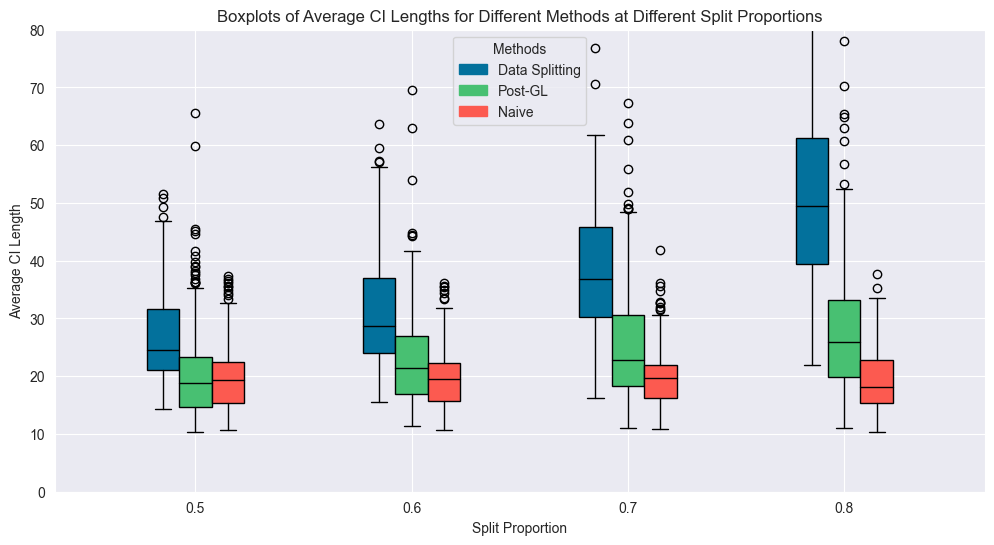

In [261]:
plot_boxplots_with_split_proportions(ci_lengths_dicts = [results_50[1], 
                                                         results_60[1],
                                                         results_70[1],
                                                         results_80[1]], 
                                     method_names = ["Data Splitting", "Post-GL", "Naive"], 
                                     split_proportions = [0.5, 0.6, 0.7, 0.8])

In [262]:
def len_df(ci_lengths_lists, method_names, split_proportions):
    # ci_lengths_lists: [list_50, list_60, list_70]
    # list_50: [len_ds, len_postGL, len_naive]
    full_dict = {"method":[], "proportion":[], "avg length": []}
    for i, list_i in enumerate(ci_lengths_lists):
        for j, l in enumerate(list_i):
            len_l = len(l)
            full_dict["avg length"] += l
            full_dict["method"] += [method_names[j]] * len_l
            full_dict["proportion"] += [split_proportions[i]] * len_l
    
    return pd.DataFrame(full_dict)

In [263]:
len_data_frame = len_df([results_50[1], results_60[1], results_70[1], results_80[1]], 
                        method_names = ["Data splitting", "Post-GL", "Naive"], 
                        split_proportions = [0.5, 0.6, 0.7, 0.8])

In [264]:
len_data_frame.to_csv('NHANES_len.csv', index=False)

# Number of infinitely long intervals for data splitting

In [265]:
proportions = [0.5, 0.6, 0.7, 0.8]
n_sims = 500
inf_prop = [results_50[2]/n_sims, results_60[2]/n_sims,
            results_70[2]/n_sims, results_80[2]/n_sims]

In [266]:
inf_prop

[0.366, 0.446, 0.538, 0.736]

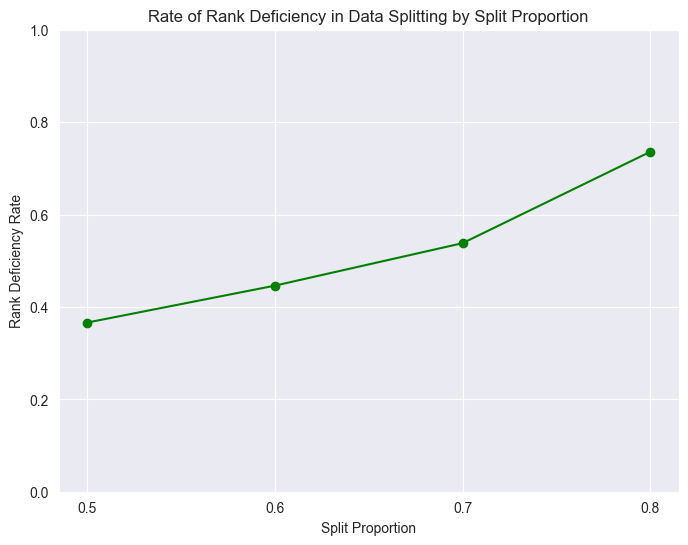

In [267]:
plt.figure(figsize=(8,6))
plt.plot(proportions, inf_prop, marker='o', linestyle='-', color='g')
plt.title('Rate of Rank Deficiency in Data Splitting by Split Proportion')
plt.xlabel('Split Proportion')
plt.ylabel('Rank Deficiency Rate')
plt.ylim(0, 1)
plt.xticks(proportions)
plt.grid(True)
plt.show()

# Visualizing One Subsample

In [268]:
np.random.seed(100)
Y_sub, X_sub = stratified_sampling(design_X=design_X,
                                   Y=Y, split_proportion=0.1)

In [269]:
X_sub.shape

(599, 48)

In [270]:
np.linalg.matrix_rank(X_sub)

48

## Data Splitting

In [271]:
weight_const = 0.5
proportion = 0.67
n, p = X_sub.shape

In [272]:
np.random.seed(1000)
rank_def_ds, MLestimates_ds, intervals_ds, pval_ds, nonzero_ds, group_pvals_ds\
    = data_splitting(X=X_sub, Y=Y_sub, n=n, p=p, groups=groups,
                     group_sizes=sizes, weight_frac=weight_const / np.sqrt(avg_sizes),
                     proportion=proportion)

In [273]:
np.random.seed(1000)
MLestimates_naive, intervals_naive, pval_naive, nonzero_naive, group_pvals_naive = \
    naive_inference(X=X_sub, Y=Y_sub, n=n, p=p,
                    groups=groups,group_sizes=sizes,
                    weight_frac=weight_const / np.sqrt(avg_sizes))

In [274]:
np.random.seed(1000)
MLestimates_r, intervals_r, pval_r, nonzero_r, group_pvals_r = (
    randomized_inference(X=X_sub, Y=Y_sub, n=n, p=p,
                     groups=groups, group_sizes=sizes,
                     weight_frac=weight_const / np.sqrt(avg_sizes), proportion=proportion))

In [275]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_ds))
print(np.array(pval_r))

[0.0001 0.427  0.083  0.1798 0.0951 0.8294 0.2499 0.6624]
[0.     0.0754 0.0296 0.1358 0.4627]


In [276]:
def plot_single_confidence_interval(x, point_est, interval,
                                    color='#2187bb', horizontal_line_width=0.25):

    left = x - horizontal_line_width / 2
    top = interval[0]
    right = x + horizontal_line_width / 2
    bottom = interval[1]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, point_est, 'o', color='#f44336')

def plot_full_CIs(point_ests, intervals, col_names, nonzero, title):
    plt.figure(figsize=(10,6))
    col_names = np.array(col_names)
    E_card = len(col_names[nonzero])
    selected_col_names = col_names[nonzero]
    plt.xticks(list(range(1, E_card+1)), selected_col_names,
               rotation=360-45, ha='left')
    plt.title(title)
    for j in range(E_card):
        plot_single_confidence_interval(j+1, point_est=point_ests[j],
                                        interval=intervals[j])
    plt.show()


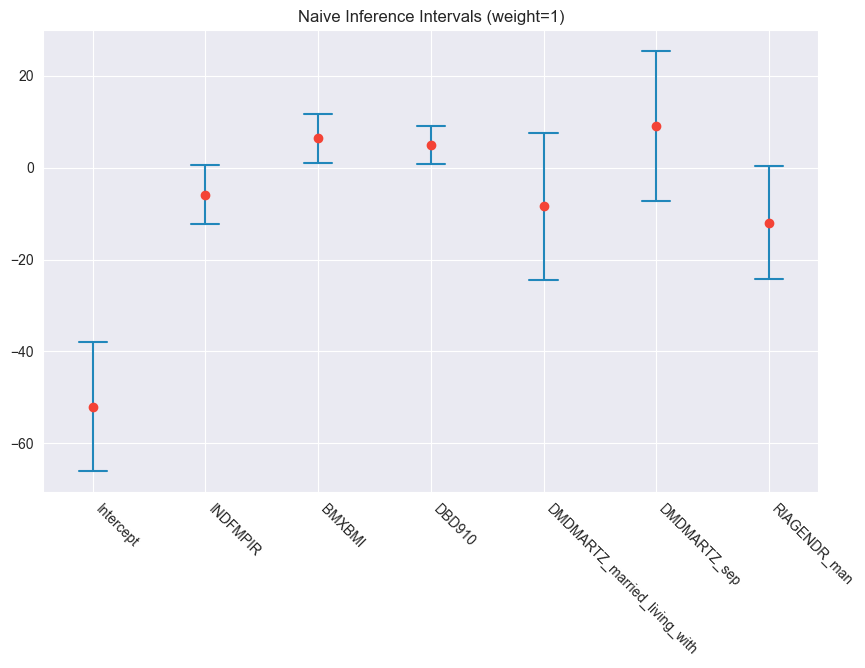

In [277]:
plot_full_CIs(MLestimates_naive, intervals_naive, col_names, nonzero_naive,
              "Naive Inference Intervals (weight=1)")

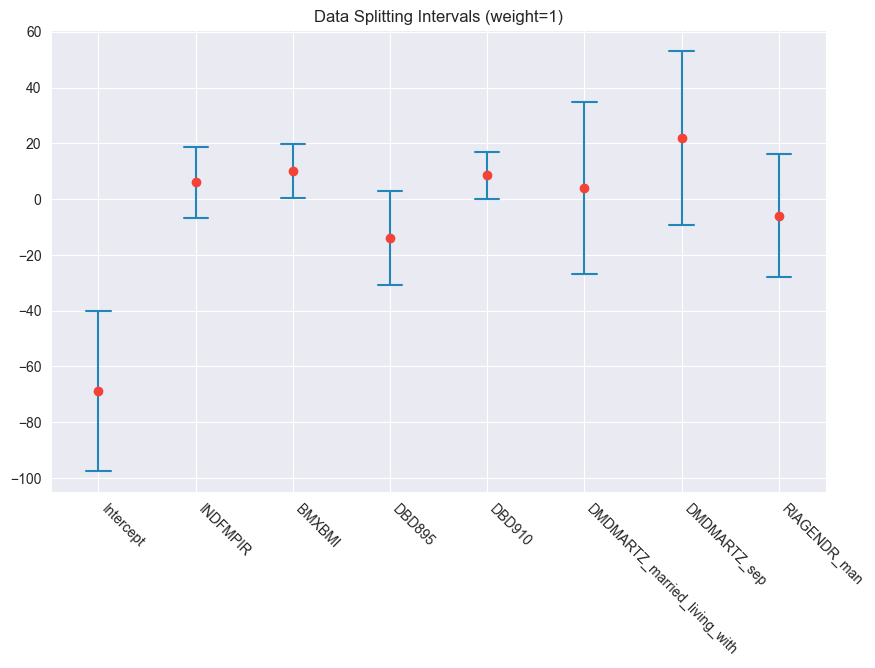

In [278]:
plot_full_CIs(MLestimates_ds, intervals_ds, col_names, nonzero_ds,
              "Data Splitting Intervals (weight=1)")

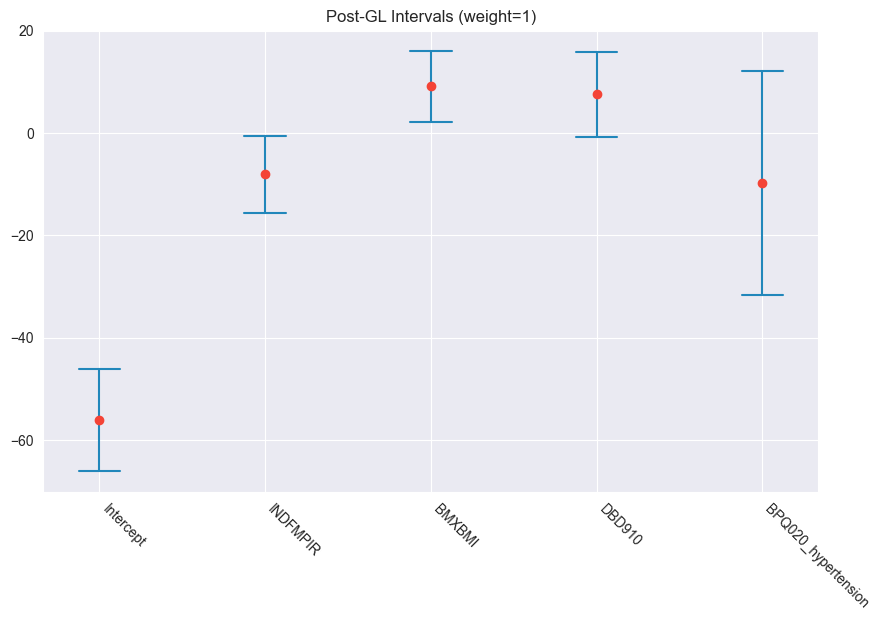

In [279]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Post-GL Intervals (weight=1)")

### Comparing outputs of different methods

In [280]:
def tabulate_results(nonzero_list,intervals_list,groups=groups,colnames=col_names,
                     path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append("(" + str(round(interval_l,3)) + ","
                                   + str(round(interval_u,3)) + ")")
                    else:
                        row.append("-")
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df


In [307]:
def tabulate_results_separate(nonzero_list,intervals_list,
                              p_values_list,group_pvalues_list,
                              groups=groups, colnames=col_names, path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            for k in range(len(nonzero_list)):
                if nonzero_list[k][j]:
                    selected = True
            # Include this into the summary if selected
            if selected:
                row = []

                row.append(i) # Record group index
                # iterate over all methods
                for l in range(len(nonzero_list)):
                    if nonzero_list[l][j]:
                        idx_among_selected = np.sum(nonzero_list[l][0:j])
                        interval_l = intervals_list[l][idx_among_selected,0]
                        interval_u = intervals_list[l][idx_among_selected,1]
                        row.append(interval_l)
                        row.append(interval_u)
                        row.append(p_values_list[l][idx_among_selected])
                        row.append(group_pvalues_list[l][i])
                    else:
                        row.append(0)
                        row.append(0)
                        row.append(1.)
                        row.append(1.)

                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    """
    avg_len = []
    for k in range(len(nonzero_list)):
        interval_l = intervals_list[k][:,0]
        interval_u = intervals_list[k][:,1]
        avg_len.append(np.mean(interval_u - interval_l))
    row_df = pd.DataFrame(avg_len).T
    output_df = pd.concat([output_df, row_df], axis=0)
    selected_varnames.append("Avg. CI Length")
    """

    output_df.index = selected_varnames
    if path is not None:
        output_df.to_csv(path)

    return output_df

In [308]:
def tabulate_one_method(nonzero,intervals,estimates,p_values,groups=groups,
                        colnames=col_names, path=None):
    output_df = pd.DataFrame()
    selected_varnames = []
    for i in set(groups):
        group_i_indices = np.where(groups==i)[0]
        for j in group_i_indices:
            selected = False
            if nonzero[j]:
                selected = True
            # Include this into the summary if selected
            if selected:
                row = []
                if nonzero[j]:
                    idx_among_selected = np.sum(nonzero[0:j])
                    interval_l = intervals[idx_among_selected,0]
                    interval_u = intervals[idx_among_selected,1]
                    row.append(interval_l)
                    row.append(interval_u)
                    row.append(estimates[idx_among_selected])
                    row.append(p_values[idx_among_selected])
                row_df = pd.DataFrame(row).T
                output_df = pd.concat([output_df, row_df], axis=0)
                selected_varnames.append(col_names[j])

    output_df.index = selected_varnames
    output_df.columns = ["Lower", "Upper", "MLE", "P value"]
    if path is not None:
        output_df.to_csv(path)

    return output_df

In [309]:
groups

array([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,
       10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13,
       13, 13, 13, 14, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [310]:
nonzero_list = [nonzero_r, nonzero_ds, nonzero_naive]
intervals_list = [intervals_r, intervals_ds, intervals_naive]
output_comparison = tabulate_results(nonzero_list=nonzero_list,
                                     intervals_list=intervals_list)

In [311]:
output_comparison.columns = ["Hessian Randomized", "Data splitting",  "Naive"]

In [312]:
output_comparison

,Hessian Randomized,Data splitting,Naive
Intercept,"(-66.13,-46.057)","(-97.616,-40.212)","(-66.154,-37.95)"
INDFMPIR,"(-15.595,-0.607)","(-6.569,18.837)","(-12.27,0.549)"
BMXBMI,"(2.219,15.97)","(0.521,19.817)","(1.116,11.713)"
DBD895,-,"(-30.688,3.119)",-
DBD910,"(-0.776,15.894)","(0.123,16.901)","(0.742,9.03)"
DMDMARTZ_married_living_with,-,"(-26.851,34.944)","(-24.392,7.653)"
DMDMARTZ_sep,-,"(-9.376,53.031)","(-7.181,25.356)"
RIAGENDR_man,-,"(-27.887,16.189)","(-24.295,0.342)"
BPQ020_hypertension,"(-31.703,12.131)",-,-
Avg. CI Length,21.862947,40.12105,21.303699


In [313]:
output_comparison.round(3).to_csv("weight0.5_CIs.csv", index=True)

In [314]:
output_ds_05 = tabulate_one_method(nonzero=nonzero_ds,
                                  intervals=intervals_ds,
                                  estimates=MLestimates_ds,
                                  p_values=pval_ds,
                                  path="weight0.5_ds.csv")
output_naive_05 = tabulate_one_method(nonzero=nonzero_naive,
                                  intervals=intervals_naive,
                                  estimates=MLestimates_naive,
                                  p_values=pval_naive,
                                  path="weight0.5_naive.csv")
output_random_05 = tabulate_one_method(nonzero=nonzero_r,
                                  intervals=intervals_r,
                                  estimates=MLestimates_r,
                                  p_values=pval_r,
                                  path="weight0.5_r.csv")

In [315]:
nonzero_list = [nonzero_naive, nonzero_ds, nonzero_r]
intervals_list = [intervals_naive, intervals_ds, intervals_r]
pvalues_list = [pval_naive, pval_ds, pval_r]
group_pvals_list = [group_pvals_naive, group_pvals_ds, group_pvals_r]
output_separated = tabulate_results_separate(nonzero_list=nonzero_list,
                                             intervals_list=intervals_list,
                                             p_values_list=pvalues_list,
                                             group_pvalues_list=group_pvals_list)

In [316]:
group_pvals_r

{0: 3.818350700327766e-20,
 2: 0.0753870271167806,
 3: 0.02958398984365896,
 6: 0.13577047521739372,
 18: 0.4626771055809089}

In [317]:
output_separated.columns = ["Group Index",
                            "N_L", "N_U", "N_pval", "N_grouppval", # Naive
                            "DS_L", "DS_U", "DS_pval", "DS_grouppval", # DS
                            "HR_L", "HR_U", "HR_pval", "HR_grouppval", # Hessian-randomized
                            ]

In [318]:
output_separated

,Group Index,N_L,N_U,N_pval,N_grouppval,DS_L,DS_U,DS_pval,DS_grouppval,HR_L,HR_U,HR_pval,HR_grouppval
Intercept,0.0,-66.154458,-37.949787,1.269568e-09,1.269568e-09,-97.615733,-40.211785,0.000078,0.000078,-66.130161,-46.057207,3.818351e-20,3.818351e-20
INDFMPIR,2.0,-12.270110,0.549274,1.326074e-01,1.326074e-01,-6.568545,18.836599,0.427024,0.427024,-15.594548,-0.607065,7.538703e-02,7.538703e-02
BMXBMI,3.0,1.116250,11.712760,4.643743e-02,4.643743e-02,0.521200,19.817202,0.082969,0.082969,2.218626,15.969845,2.958399e-02,2.958399e-02
DBD895,4.0,0.000000,0.000000,1.000000e+00,1.000000e+00,-30.687764,3.119472,0.179822,0.179822,0.000000,0.000000,1.000000e+00,1.000000e+00
DBD910,6.0,0.742240,9.029503,5.244134e-02,5.244134e-02,0.122747,16.901021,0.095133,0.095133,-0.775923,15.893779,1.357705e-01,1.357705e-01
DMDMARTZ_married_living_with,9.0,-24.391825,7.653353,3.902453e-01,9.390914e-02,-26.850671,34.943612,0.829440,0.093437,0.000000,0.000000,1.000000e+00,1.000000e+00
DMDMARTZ_sep,9.0,-7.180608,25.355582,3.581854e-01,9.390914e-02,-9.375830,53.031483,0.249888,0.093437,0.000000,0.000000,1.000000e+00,1.000000e+00
RIAGENDR_man,15.0,-24.294758,0.341939,1.097773e-01,1.097773e-01,-27.887256,16.188949,0.662429,0.662429,0.000000,0.000000,1.000000e+00,1.000000e+00
BPQ020_hypertension,18.0,0.000000,0.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,1.000000,1.000000,-31.702739,12.130639,4.626771e-01,4.626771e-01


In [319]:
pval_table = output_separated[["HR_pval", "HR_grouppval", "DS_pval", "DS_grouppval",
                                "N_pval", "N_grouppval"]]

In [320]:
pval_table.round(3)

,HR_pval,HR_grouppval,DS_pval,DS_grouppval,N_pval,N_grouppval
Intercept,0.000,0.000,0.000,0.000,0.000,0.000
INDFMPIR,0.075,0.075,0.427,0.427,0.133,0.133
BMXBMI,0.030,0.030,0.083,0.083,0.046,0.046
DBD895,1.000,1.000,0.180,0.180,1.000,1.000
DBD910,0.136,0.136,0.095,0.095,0.052,0.052
DMDMARTZ_married_living_with,1.000,1.000,0.829,0.093,0.390,0.094
DMDMARTZ_sep,1.000,1.000,0.250,0.093,0.358,0.094
RIAGENDR_man,1.000,1.000,0.662,0.662,0.110,0.110
BPQ020_hypertension,0.463,0.463,1.000,1.000,1.000,1.000


In [321]:
pval_table.round(3).to_csv("weight0.5.csv", index=True)